In [1]:
#Imports
import os
import copy
import pandas as pd
import tensorflow as tf
from keras import backend as K
import scipy.stats as stats

import sys
sys.path.insert(0, '..')
from utils.modelgenerator import *
from utils.modelhandler import *
from utils.datahandler import *
from utils.attackhandler import *

import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

### Data

In [2]:
file_path = os.path.join(os.path.normpath(os.path.dirname(os.path.dirname(os.getcwd()))), 'data/3final_data/Final_Energy_dataset.csv')
cwd = os.path.normpath(os.getcwd())
use_sin_cos_features = True

# User indices based on clusters
user_indices = [16, 24] # Cluster 2: [16,24] / Cluster 4: [1, 11, 12, 27] / Cluster 10: [2, 4, 6, 9, 10, 14, 15, 18, 25, 30]

# Data processing parameters
sequence_length = 49
batch_size = 16

# Initialize necessary objects
dh = Datahandler()
m1 = ModelGenerator()
mh = Modelhandler()

# Load and prepare data
print("Loading and preparing data...")
df_array = load_and_prepare_data(file_path, user_indices, columns_filter_prefix="load")

# Apply sine and cosine transformations if the flag is set to True
if use_sin_cos_features:
    for i in range(len(df_array)):
        df_array[i] = create_sin_cos_features(df_array[i])

# Split the data into training, validation, and test sets
print("Splitting data into train, validation, and test sets...")
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_array, sequence_length, batch_size, dh)


X_train_raw = X_train

loss = tf.keras.losses.MeanSquaredError()
metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()]
callbacks = get_callbacks()

Loading and preparing data...
Splitting data into train, validation, and test sets...


In [3]:
# Attack with ZERO
def backdoor_attack_at_time_withZero(X_train, hours=[0, 1], user="user1"):
    masks = []

    # Loop through each hour in the hours array
    for hour in hours:
        # Calculate sine and cosine values for the hour
        hour_sin = np.sin(hour * 2 * np.pi / 24).round(4)  # sin(hour/24 * 2π)
        hour_cos = np.cos(hour * 2 * np.pi / 24).round(4)  # cos(hour/24 * 2π)

        # Scale values to range [0, 1]
        hour_sin_scaled = (hour_sin + 1) / 2
        hour_cos_scaled = (hour_cos + 1) / 2

        # Create a mask for the current hour
        mask_hour = (X_train[user][:, :, 1] == hour_sin_scaled) & (X_train[user][:, :, 2] == hour_cos_scaled)
        masks.append(mask_hour)

    # Combine all the masks to target all specified hours
    combined_mask = np.any(masks, axis=0)

    # Apply noise only to the load values (first feature) for the selected times
    #X_train[user][:, :, 0][combined_mask] += np.random.normal(loc=0.0, scale=noise_scale, size=combined_mask.sum())
    X_train[user][:, :, 0][combined_mask] = 0

    return X_train

attack = "FL_Load_BACKDOOR_ZERO_LocalRetraining"
X_train = copy.deepcopy(X_train_raw)
X_train

{'user1': array([[[0.38216785, 0.5       , 1.        , 0.        , 0.        ],
         [0.37447554, 0.6294    , 0.98295   , 0.        , 1.        ],
         [0.41433567, 0.6294    , 0.98295   , 0.        , 0.        ],
         ...,
         [0.35874125, 0.3706    , 0.98295   , 0.        , 1.        ],
         [0.36573428, 0.3706    , 0.98295   , 0.        , 0.        ],
         [0.36853147, 0.5       , 1.        , 0.        , 1.        ]],
 
        [[0.37447554, 0.6294    , 0.98295   , 0.        , 1.        ],
         [0.41433567, 0.6294    , 0.98295   , 0.        , 0.        ],
         [0.40874127, 0.75      , 0.933     , 0.        , 1.        ],
         ...,
         [0.36573428, 0.3706    , 0.98295   , 0.        , 0.        ],
         [0.36853147, 0.5       , 1.        , 0.        , 1.        ],
         [0.36783215, 0.5       , 1.        , 0.        , 0.        ]],
 
        [[0.41433567, 0.6294    , 0.98295   , 0.        , 0.        ],
         [0.40874127, 0.75      , 

# Backdoor Attacks

In [3]:
#No Attack

#NORMAL DISTRIBUTION - Scale 1
#attack = "FL_Load_noBACKDOOR_noBACKDOORNoise"
#X_train = copy.deepcopy(X_train_raw)
#X_train = backdoor_attack_at_time(X_train, noise_scale=1.0)

#plot_impact_of_attack_noise(X_train_raw, X_train, user="user1", features=True)

#Run Tests
#run_federated_training(df_array, X_train, y_train, X_val, y_val, X_test, y_test, callbacks, m1, mh, attack, cwd, loss, metrics)
#aggregated_results, all_results = run_federated_local_evaluation(df_array, X_train, y_train, X_val, y_val, X_test, y_test, callbacks, m1, mh, attack, cwd, loss, metrics)

#save_dictionaries([
#    (f"{attack}_aggregated_results", aggregated_results), 
#    (f"{attack}_all_results", all_results)], folder_name="results/")

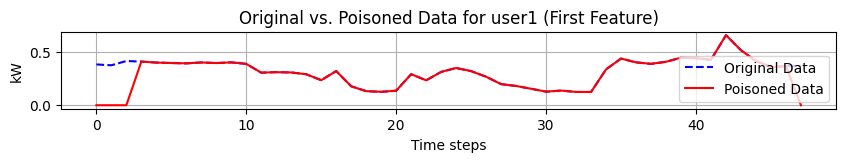

FL: Saved Global models - round  0  (fed_round  0 )
FL: Saved Global models - round  0  (fed_round  1 )
FL: Saved Global models - round  0  (fed_round  2 )
FL: Saved Global models - round  1  (fed_round  0 )
FL: Saved Global models - round  1  (fed_round  1 )
FL: Saved Global models - round  1  (fed_round  2 )
FL: Saved Global models - round  2  (fed_round  0 )
FL: Saved Global models - round  2  (fed_round  1 )
FL: Saved Global models - round  2  (fed_round  2 )
Evaluation: Building:  1  - round  0
Evaluation: Building:  1  - round  1
Evaluation: Building:  1  - round  2
Evaluation: Building:  2  - round  0
Evaluation: Building:  2  - round  1
Evaluation: Building:  2  - round  2
Dictionaries saved successfully!


In [4]:
# Attack with ZERO
def backdoor_attack_at_time_withZero(X_train, hours=[0, 1], user="user1"):
    masks = []

    # Loop through each hour in the hours array
    for hour in hours:
        # Calculate sine and cosine values for the hour
        hour_sin = np.sin(hour * 2 * np.pi / 24).round(4)  # sin(hour/24 * 2π)
        hour_cos = np.cos(hour * 2 * np.pi / 24).round(4)  # cos(hour/24 * 2π)

        # Scale values to range [0, 1]
        hour_sin_scaled = (hour_sin + 1) / 2
        hour_cos_scaled = (hour_cos + 1) / 2

        # Create a mask for the current hour
        mask_hour = (X_train[user][:, :, 1] == hour_sin_scaled) & (X_train[user][:, :, 2] == hour_cos_scaled)
        masks.append(mask_hour)

    # Combine all the masks to target all specified hours
    combined_mask = np.any(masks, axis=0)

    # Apply noise only to the load values (first feature) for the selected times
    #X_train[user][:, :, 0][combined_mask] += np.random.normal(loc=0.0, scale=noise_scale, size=combined_mask.sum())
    X_train[user][:, :, 0][combined_mask] = 0

    return X_train

attack = "FL_Load_BACKDOOR_ZERO_LocalRetraining"
X_train = copy.deepcopy(X_train_raw)
X_train = backdoor_attack_at_time_withZero(X_train)

plot_impact_of_attack_noise(X_train_raw, X_train, user="user1", features=True)

#Run Tests
run_federated_training(df_array, X_train, y_train, X_val, y_val, X_test, y_test, callbacks, m1, mh, attack, cwd, loss, metrics)
aggregated_results2, all_results2 = run_federated_local_evaluation(df_array, X_train, y_train, X_val, y_val, X_test, y_test, callbacks, m1, mh, attack, cwd, loss, 
                                                                   metrics, max_epochs=100)

save_dictionaries([
    (f"{attack}_aggregated_results", aggregated_results2), 
    (f"{attack}_all_results", all_results2)], folder_name="results/")


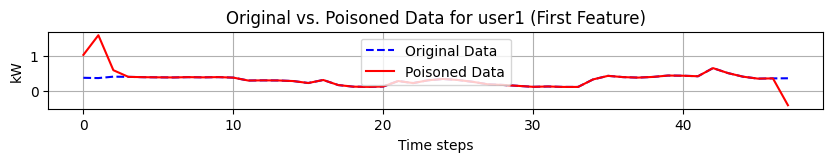

FL: Saved Global models - round  0  (fed_round  0 )
FL: Saved Global models - round  0  (fed_round  1 )
FL: Saved Global models - round  0  (fed_round  2 )
FL: Saved Global models - round  1  (fed_round  0 )
FL: Saved Global models - round  1  (fed_round  1 )
FL: Saved Global models - round  1  (fed_round  2 )
FL: Saved Global models - round  2  (fed_round  0 )
FL: Saved Global models - round  2  (fed_round  1 )
FL: Saved Global models - round  2  (fed_round  2 )
Evaluation: Building:  1  - round  0
Evaluation: Building:  1  - round  1
Evaluation: Building:  1  - round  2
Evaluation: Building:  2  - round  0
Evaluation: Building:  2  - round  1
Evaluation: Building:  2  - round  2
Dictionaries saved successfully!


In [5]:
#Attack with RANDOM NOISE
attack = "FL_Load_BACKDOOR_NormBACKDOOR1_LocalRetraining"
X_train = copy.deepcopy(X_train_raw)
X_train = backdoor_attack_at_time(X_train, noise_scale=1.0)

plot_impact_of_attack_noise(X_train_raw, X_train, user="user1", features=True)

#Run Tests
run_federated_training(df_array, X_train, y_train, X_val, y_val, X_test, y_test, callbacks, m1, mh, attack, cwd, loss, metrics)
aggregated_results3, all_results3 = run_federated_local_evaluation(df_array, X_train, y_train, X_val, y_val, X_test, y_test, callbacks, m1, mh, attack, cwd, loss,
                                                                    metrics, max_epochs=100)

save_dictionaries([
    (f"{attack}_aggregated_results", aggregated_results3), 
    (f"{attack}_all_results", all_results3)], folder_name="results/")

In [6]:
import requests
import os

def send_telegram_message(bot_token, chat_id, message):
    """Send a message to a Telegram chat via the Bot API."""
    url = f"https://api.telegram.org/bot{bot_token}/sendMessage"
    payload = {
        "chat_id": chat_id,
        "text": message,
        "parse_mode": "Markdown"
    }
    response = requests.post(url, json=payload)
    return response.json()

# Use the function
bot_token = os.getenv('TELEGRAM_BOT_TOKEN')
chat_id = os.getenv('TELEGRAM_CHAT_ID')
message = f"Script .81!"

result = send_telegram_message(bot_token, chat_id, message)
print(result)

{'ok': True, 'result': {'message_id': 308, 'from': {'id': 7071194232, 'is_bot': True, 'first_name': 'Reinforcement Learning', 'username': 'FederatedRL_Bot'}, 'chat': {'id': 5493937056, 'first_name': 'Jonas', 'last_name': 'Sievers', 'username': 'JonasSievers', 'type': 'private'}, 'date': 1724554167, 'text': 'Script .81!'}}


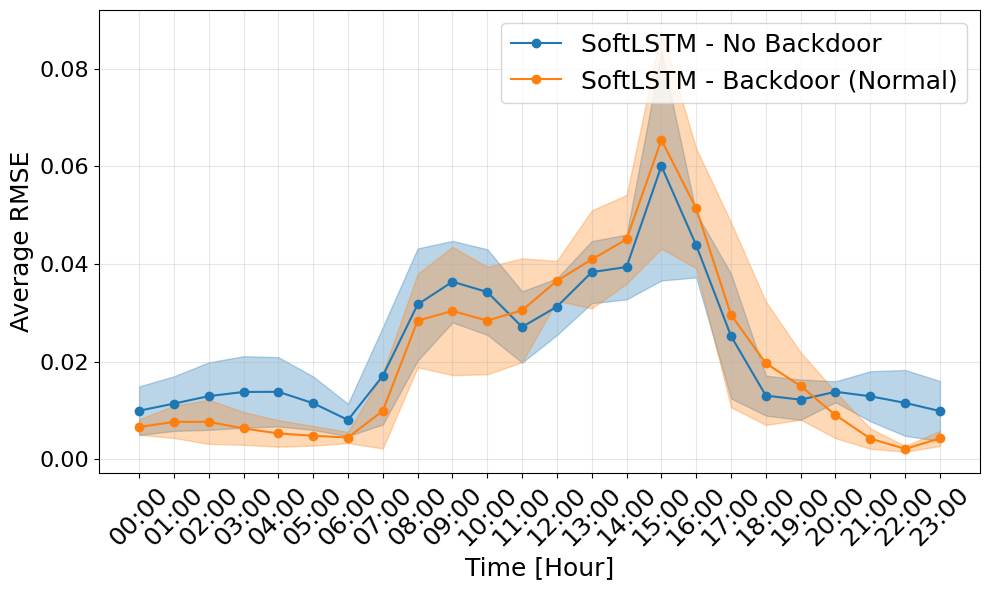

In [36]:
energy = "PV"

# Define the models, their labels, and colors
models = ["softlstm"] #"cnn","bilstm", "softlstm", "softdense"
model_labels = {
    "cnn": "CNN",
    "bilstm": "BiLSTM",
    "softlstm": "SoftLSTM",
    "softdense": "SoftDense"
}
file_labels = {
    f"FL_{energy}_noBACKDOOR_noBackdoorNoise_all_results.pkl": "No Backdoor",
    f"FL_{energy}_BACKDOOR_NormBackdoor1_all_results.pkl": "Backdoor (Normal)",
    #"FL_Load_BACKDOOR_ZERO_all_results.pkl": "Backdoor (Zero)"
}
model_colors = {
    f"FL_{energy}_noBACKDOOR_noBackdoorNoise_all_results.pkl": "#1f77b4",
    f"FL_{energy}_BACKDOOR_NormBackdoor1_all_results.pkl": "#ff7f0e",
    #"FL_Load_BACKDOOR_ZERO_all_results.pkl": "#2ca02c"
}

# List of files
files = [
    f"FL_{energy}_noBACKDOOR_noBackdoorNoise_all_results.pkl", 
    f"FL_{energy}_BACKDOOR_NormBackdoor1_all_results.pkl", 
    #"FL_Load_BACKDOOR_ZERO_all_results.pkl"
]

user="user2"

for selected_model in models:
    plt.figure(figsize=(10, 6))

    # Iterate over the files and plot results for the selected model
    for file in files:
        with open(f"results/{file}", 'rb') as f:
            all_results = pickle.load(f)

        # Get the first 144 results for the selected model
        df = copy.deepcopy(all_results[f"{selected_model}_all_results"][all_results[f"{selected_model}_all_results"]["user"] == user])
        
        # Create the time column and convert to datetime, but only keep the hour component
        df['time'] = pd.to_datetime(df['hour'], format='%H')

        # Calculate the average RMSE and standard deviation per time
        grouped = df.groupby('time')['rmse'].agg(['mean', 'std']).reset_index()
        
        # Sort the values by time
        grouped = grouped.sort_values('time')

        # Plot the average RMSE per time for the selected model from the current file
        plt.plot(grouped['time'].dt.strftime('%H:%M'), 
                    grouped['mean'], 
                    marker='o', 
                    label=f"{model_labels[selected_model]} - {file_labels[file]}", 
                    color=model_colors[file])

        # Plot the standard deviation as a shaded area (transparent background)
        plt.fill_between(grouped['time'].dt.strftime('%H:%M'), 
                            grouped['mean'] - grouped['std'], 
                            grouped['mean'] + grouped['std'], 
                            color=model_colors[file], 
                            alpha=0.3)  # Adjust the transparency level with alpha

    # Configure the plot
    plt.xlabel('Time [Hour]', fontsize=18)
    plt.ylabel('Average RMSE', fontsize=18)
    plt.xticks(rotation=45, fontsize=18)
    plt.yticks(fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=18)
    plt.tight_layout()
    
    plt.savefig(f"figures/{energy}_backdoor_{user}.pdf")
    # Display the plot
    plt.show()
